# **Figure 1 Notebook**

This notebook provides tools and data to recreate the figure 1 from Naik et al 2026. 
It has been modified code from the original repo to allow for data retrival from the datashare and plotting using standarized versions of the code to plot the figures. 

**Author**: Suyash Naik

In [2]:
from src.BinnedPlotter import BinnedIntensityPlotter
from src.Figureplot import setup_figure,build_nd_raw_dataset,plot_nd_surface
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re 

Figureplot.py run on  20260207


In [2]:
''' Figure panel C: Binned intensity plot of keratin network maturation in EVL cells
Averaged keratin intensity within the EVL in Tg(krt18:Krt18-GFP) embryos as a 
function of time during epiboly (4 - 9.5 hpf).
N = 3 experiments, n = 6 embryos. 
Error bars as ribbons representing SEM plotted along mean.'''

Fig1folder= "/home/snaik/Projects/PaperPublishgit/data/"
panelc=Fig1folder+"Fig1/1C/"
intensity_files = glob(os.path.join(panelc, "*.csv"))
outputfolder="Figure/Figure1/PanelC/"
os.makedirs(outputfolder, exist_ok=True)
print(f"Panel C has {len(intensity_files)} files binned and plotted. Output saved in {outputfolder} folder.")

Panel C has 6 files binned and plotted. Output saved in Figure/Figure1/PanelC/ folder.


  0%|                                                                                                                                                                                           | 0/6 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 48.70it/s]


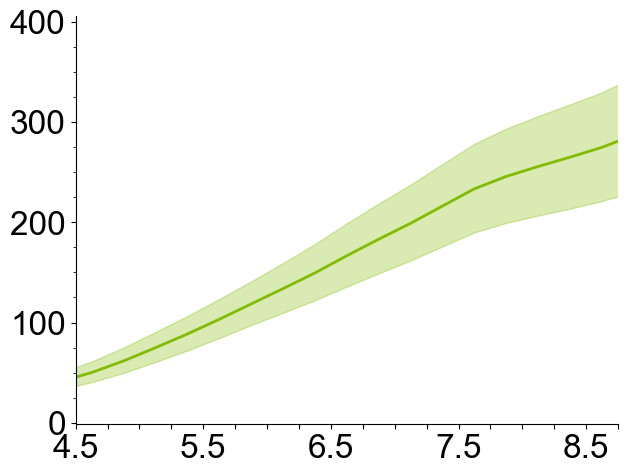

In [3]:
intensityData=pd.DataFrame()
binnedIntensityData=pd.DataFrame()
bin_edges= np.arange(4,10,0.25)
# Compute the bin averages
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
binnedIntensityData["Time (hpf)"]=bin_centers
bin_averages = np.zeros(len(bin_centers))
for file in tqdm(intensity_files):
    if file.find("0804")==-1:
        data = pd.read_csv(file)
        data["Label"]="23022021"+file.split("Pos")[1][0:3]
        data["Time"]=[(x-1)*15.5/60+4 for x in data[" "]]
        intensityData = pd.concat([intensityData,data])
        for i in range(len(bin_centers)):
            bin_averages[i] = np.mean(data["Mean"][(data["Time"]>bin_edges[i]) & (data["Time"]<bin_edges[i+1])])
        binnedIntensityData["23022021_"+file.split("Pos")[1][0:3]]=bin_averages

    

    else:
        data = pd.read_csv(file)

        

        data["Time"]=[(x-1)*5.2/60+4 for x in data[" "]]
        intensityData = pd.concat([intensityData,data])
        for i in range(len(bin_centers)):
            bin_averages[i] = np.mean(data["Mean"][(data["Time"]>bin_edges[i]) & (data["Time"]<bin_edges[i+1])])
        binnedIntensityData["08042021_"+file.split("Pos")[1][0:3]]=bin_averages
binnedIntensityData.to_csv(outputfolder+"Figure1D_binnedIntensityData.csv")
#plot the average of columns 1: data in binnedIntensityData dataframe as a line plot with error bars as a ribbon around the line

fig, ax = setup_figure()

#ax.set_xlabel("Time (hpf)")
#ax.set_ylabel("Keratin Intensity (A.U.)")
ax.set_xlim(4.5,8.5)
ax.set_xticks(np.arange(4.5,9,0.25))
ax.set_xticklabels(["4.5","","","","5.5","","","","6.5","","","","7.5","","","","8.5",""])
ax.set_yticks(np.arange(0,470,25),minor=True)
ax.plot(binnedIntensityData["Time (hpf)"],binnedIntensityData.iloc[:,1:5].mean(axis=1),color="#83bb03",linewidth=2)
#ax.scatter(binnedIntensityData["Time (hpf)"],binnedIntensityData.iloc[:,1:5].mean(axis=1),color="#83bb03",s=4)
ax.fill_between(binnedIntensityData["Time (hpf)"],binnedIntensityData.iloc[:,1:5].mean(axis=1)-binnedIntensityData.iloc[:,1:5].sem(axis=1),binnedIntensityData.iloc[:,1:5].mean(axis=1)+binnedIntensityData.iloc[:,1:5].sem(axis=1),color="#83bb03",alpha=0.3)
fig.savefig(outputfolder+"Figure1D_KeratinIntensity_nolab.png",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"Figure1D_KeratinIntensity_nolab.pdf",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"Figure1D_KeratinIntensity_nolab.svg",dpi=300,bbox_inches='tight',transparent=True)
plt.show()

In [3]:
''' 
Figure panel D: Keratin network density during epiboly progression
Averaged density of the keratin network in Tg(acbt2:Utrophin-mcherry, krt18:Krt18-GFP) embryos
as a function of time during epiboly (4 - 9.5 hpf). N = 3, n = 3 embryos. 
Error bars as ribbons representing SEM plotted along mean.
'''
ndfolders = glob("data/Fig1/1D/*")
outputfolder="Figure/Figure1/PanelD/"
os.makedirs(outputfolder,exist_ok=True)
print(f"Panel D has {len(ndfolders)} files binned and plotted. Output saved in {outputfolder} folder.")

Panel D has 3 files binned and plotted. Output saved in Figure/Figure1/PanelD/ folder.


In [4]:
timebins = np.arange(4, 10, 0.5)
ndBins = pd.DataFrame({"Time (hpf)": timebins})

def extract_time_idx(path):
    m = re.findall(r"(\d+)(?=\.csv$)", path)
    if m:
        return int(m[-1])
    m = re.findall(r"TimeSrs(\d+)", path)
    if m:
        return int(m[-1])
    m = re.findall(r"(\d+)", os.path.basename(path))
    return int(m[-1]) if m else 0


def build_nd_dataset(folder, time_minutes, time0, id_tag, timebins, skip_patterns=None, save_name=None):
    files = sorted(glob(os.path.join(folder, "*.csv")), key=extract_time_idx)
    if skip_patterns:
        files = [f for f in files if not any(p in os.path.basename(f) for p in skip_patterns)]
    if not files:
        print(f"No CSV files found in {folder}")
        return None
    timelist, ndlist, ndsemlist = [], [], []
    arealist, areasemlist = [], []
    intensitylist, intensitysemlist = [], []
    for idx, file in enumerate(files):
        data = pd.read_csv(file)
        time = time0 + (idx + 1) * time_minutes / 60
        timelist.append(time)
        ndlist.append(data["%Area"].mean())
        ndsemlist.append(data["%Area"].sem())
        arealist.append(data["Area"].mean())
        areasemlist.append(data["Area"].sem())
        intensitylist.append(data["Mean"].mean())
        intensitysemlist.append(data["Mean"].sem())
    ndpd = pd.DataFrame({
        "Time (hpf)": timelist,
        "NetworkDensity": ndlist,
        "NetworkDensity_SEM": ndsemlist,
        "Area": arealist,
        "Area_SEM": areasemlist,
        "Intensity": intensitylist,
        "Intensity_SEM": intensitysemlist,
    })
    processed_dir = os.path.join(folder, "Processed")
    os.makedirs(processed_dir, exist_ok=True)
    if save_name is None:
        save_name = f"{id_tag}_NetworkPd.csv"
    ndpd.to_csv(os.path.join(processed_dir, save_name), index=False)

    ndBins[f"{id_tag}_NetworkDensity"] = np.zeros(len(timebins))
    ndBins[f"{id_tag}_NetworkDensity_SEM"] = np.zeros(len(timebins))
    ndBins[f"{id_tag}_Area"] = np.zeros(len(timebins))
    ndBins[f"{id_tag}_Area_SEM"] = np.zeros(len(timebins))
    ndBins[f"{id_tag}_Intensity"] = np.zeros(len(timebins))
    ndBins[f"{id_tag}_Intensity_SEM"] = np.zeros(len(timebins))
    for i in range(len(timebins) - 1):
        mask = (ndpd["Time (hpf)"] > timebins[i]) & (ndpd["Time (hpf)"] < timebins[i + 1])
        ndBins.loc[i, f"{id_tag}_NetworkDensity"] = ndpd["NetworkDensity"][mask].mean()
        ndBins.loc[i, f"{id_tag}_NetworkDensity_SEM"] = ndpd["NetworkDensity"][mask].sem()
        ndBins.loc[i, f"{id_tag}_Area"] = ndpd["Area"][mask].mean()
        ndBins.loc[i, f"{id_tag}_Area_SEM"] = ndpd["Area"][mask].sem()
        ndBins.loc[i, f"{id_tag}_Intensity"] = ndpd["Intensity"][mask].mean()
        ndBins.loc[i, f"{id_tag}_Intensity_SEM"] = ndpd["Intensity"][mask].sem()
    return ndpd
folder1control=ndfolders[0]
ndpd2503 = build_nd_dataset(
    folder1control,
    time_minutes=20,
    time0=4.0,
    id_tag="2503",
    timebins=timebins,
    skip_patterns=["25032023_EVPLMONetworkPd.csv"],
    save_name="25032023_EVPLMONetworkPd.csv",
 )
folder2control=ndfolders[2]
ndpd1801 = build_nd_dataset(
    folder2control,
    time_minutes=10,
    time0=4.5,
    id_tag="1801",
    timebins=timebins,
    save_name="18012022_Control.csv",
 )
folder3control=ndfolders[1]
ndpd2410 = build_nd_dataset(
    folder3control,
    time_minutes=15,
    time0=4.0,
    id_tag="2410",
    timebins=timebins,
    save_name="24102023_caRhoA.csv",
 )
ndBins.to_csv(outputfolder+"NetworkDensityData_3_16042024.csv")

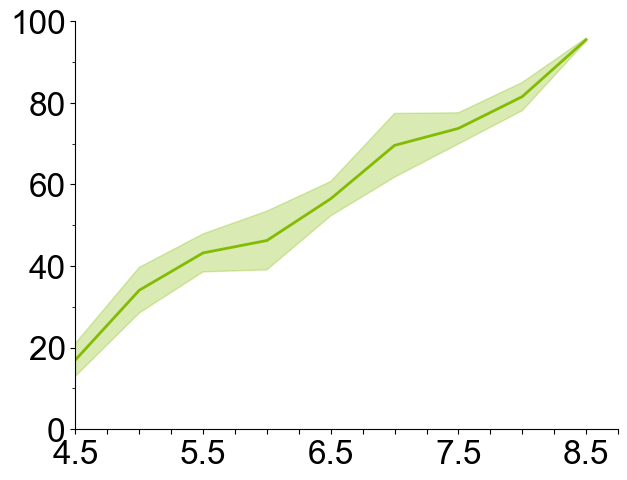

In [5]:
#Plot the average network density data in ndBins as a line with the error bars as a ribbon around the line
fig, ax = setup_figure(yticks_minor=np.arange(0,100,10))
#ax.set_xlabel("Time (hpf)")
#ax.set_ylabel("Network Density (%)")
ax.set_xlim(4.5,8.5)
ax.set_ylim(0,100)
ax.set_xticks(np.arange(4.5,9,0.25))
ax.set_xticklabels(["4.5","","","","5.5","","","","6.5","","","","7.5","","","","8.5",""])
networkavg = ndBins[["1801_NetworkDensity", "2410_NetworkDensity", "2503_NetworkDensity"]].mean(axis=1)
networksem=ndBins[["1801_NetworkDensity","2410_NetworkDensity","2503_NetworkDensity"]].sem(axis=1)
for index,value in enumerate(networksem):
    if value==np.nan:
        value=ndBins["2503_NetworkDensity_SEM"][index]
ax.plot(ndBins["Time (hpf)"],networkavg,color="#83bb03",linewidth=2)
ax.fill_between(ndBins["Time (hpf)"],networkavg-networksem,networkavg+networksem,color="#83bb03",alpha=0.3)
fig.savefig(outputfolder+"1604_NetworkDensity.png",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"1604_NetworkDensity.pdf",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"1604_NetworkDensity.svg",dpi=300,bbox_inches='tight',transparent=True)
pd.DataFrame([ndBins["Time (hpf)"],networkavg,networksem]).T.to_csv(outputfolder+"1604_NetworkDensity.csv")
plt.show()


In [ ]:
'''
Figure panel E: Apical cell area of EVL cells during epiboly
Average apical cell area of individual EVL cells in Tg(acbt2:Utrophin-mcherry, krt18:Krt18-GFP) embryos 
as a function of time during epiboly (4 hpf-8.5 hpf). N = 3, n = 5 embryos. 
Error bars as ribbons SD of mean.
'''
areafolders=glob("data/Fig1/1E/*")
outputfolder="Figure/Figure1/PanelE/"
os.makedirs(outputfolder, exist_ok=True)
print(f"Panel E has {len(areafolders)} files binned and plotted. Output saved in {outputfolder} folder.")

Panel E has 5 files binned and plotted. Output saved in Figure/Figure1/PanelE/ folder.


In [ ]:

binnedAreaData=pd.DataFrame()
timebins=np.arange(4.5,9,0.25)
for folder in areafolders:
    areapd=pd.DataFrame(columns=["Time (hpf)","Area","Label"])
    if "080421" in folder:
        time=306.50/60
        lab1="08042021"
    else:
        time=795.43/60
        lab1="11022021"

    files = glob(folder+"/R*.csv")
    if len(files) == 0:
        print(f"No CSV files found in {folder}, skipping.")
        continue

    sortedfiles = sorted(files)
    for iter,file in tqdm(enumerate(sortedfiles)):
        data=pd.read_csv(file)
        pos_match = re.search(r"Pos(\d{3})", file)
        pos_str = pos_match.group(1) if pos_match else "000"
        data["Label"]=pos_str
        areapd.loc[iter,"Area"]=data["Area"].mean()
        areapd.loc[iter,"Time (hpf)"]=(iter)*time/60+4.5
        areapd.loc[iter,"Label"]=lab1+pos_str
        areapd.to_csv(outputfolder+f"/{lab1}_{pos_str}_AreaData.csv",index=False)
    #plt.plot(areapd["Time (hpf)"],areapd["Area"],label=lab1+pos_str)

    bin_averages = np.zeros(len(timebins)-1)
    binnedAreaData["Time (hpf)"]=timebins[:-1]
    for i in range(len(timebins)-1):
        bin_averages[i] = np.mean(areapd["Area"][(areapd["Time (hpf)"]>timebins[i]) & (areapd["Time (hpf)"]<timebins[i+1])])
    binnedAreaData[lab1+"_"+pos_str]=bin_averages

binnedAreaData.to_csv(outputfolder+"Figure1E_binnedAreaData.csv")

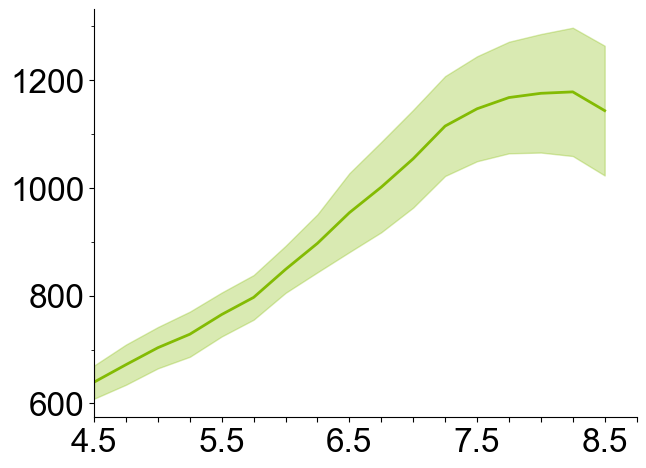

In [ ]:
fig, ax = setup_figure(yticks_minor=np.arange(0,1400,100))
ax.set_xlim(4.5,8.5)
ax.set_xticks(np.arange(4.5,9,0.25))
ax.set_xticklabels(["4.5","","","","5.5","","","","6.5","","","","7.5","","","","8.5",""])
ax.plot(binnedAreaData["Time (hpf)"],binnedAreaData.iloc[:,1:5].mean(axis=1),color="#83bb03",linewidth=2)
ax.fill_between(binnedAreaData["Time (hpf)"],binnedAreaData.iloc[:,1:5].mean(axis=1)-binnedAreaData.iloc[:,1:5].sem(axis=1),binnedAreaData.iloc[:,1:5].mean(axis=1)+binnedAreaData.iloc[:,1:5].sem(axis=1),color="#83bb03",alpha=0.3)
fig.savefig(f"{outputfolder}Fig_1EbinnedAreaGraph.png",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(f"{outputfolder}Fig_1EbinnedAreaGraph.pdf",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(f"{outputfolder}Fig_1EbinnedAreaGraph.svg",dpi=300,bbox_inches='tight',transparent=True)
plt.show()


3-dimensional (3D) plot of keratin intensity, network density, and EVL cell area as a function of time during epiboly. N = 3, n = 3 embryos. 
Spread of the surface (width) represents data spread, indicating their variability (SD of intensity and area).




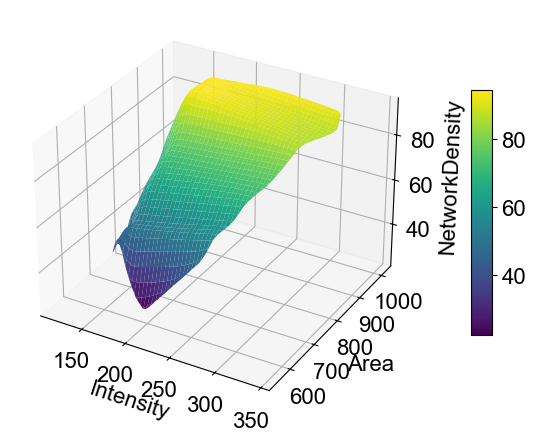

In [13]:
nd_raw= build_nd_raw_dataset(
    ndfolders=ndfolders,
    time_minutes=[20,15,10],
    time0=[4.0,4.0,4.5],
    id_tags=["2503", "2410", "1801"],
    aggregate="mean"
)
nd_raw = nd_raw.dropna(subset=["Intensity", "Area", "NetworkDensity"])
fig, ax, surf= plot_nd_surface(
    nd_raw,
    x_col="Intensity",
    y_col="Area",
    z_col="NetworkDensity",
    grid_res=500
)


**Figure Panel 1G**: Junctional vs apical keratin pool correlation

Correlation of junctional and apical keratin intensity measured in individual 

EVL cells in Tg(acbt2:Utrophin-mcherry, krt18:Krt18-GFP) embryos
at 60% epiboly stage (6 hpf) N = 3, n = 5 embryos.

In [4]:
junctionfolders=glob("data/Fig1/1G/*")
outputfolder="Figure/Figure1/PanelG/"
os.makedirs(outputfolder,exist_ok=True)
print(f"Panel G contains data from {len(junctionfolders)} embryos. Outputs are stored in {outputfolder}")

Panel G contains data from 5 embryos. Outputs are stored in Figure/Figure1/PanelG/


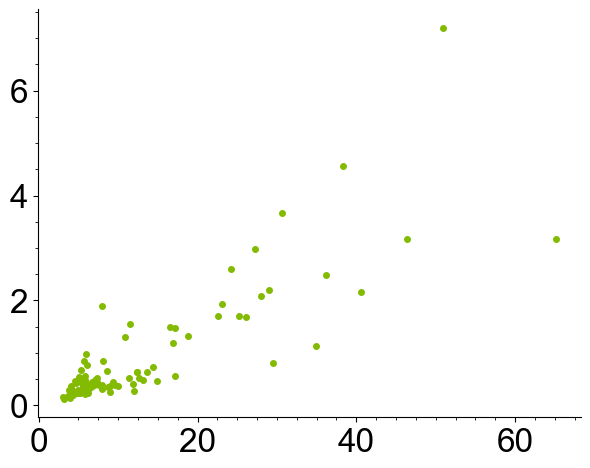

In [7]:
junctionalpd=pd.DataFrame(columns=["25032023_Junction","08022023_Junction","21032023_Junction","25032023_2_Junction","21032023_2_Junction"])
apicalpd=pd.DataFrame(columns=["25032023_Apical","08022023_Apical","21032023_Apical","25032023_2_Apical","21032023_2_Apical"])
count={}
for i,folder in enumerate(sorted(junctionfolders)):
    folderfiles=glob(folder+"/*.csv")
    date_key=re.findall(r"(\d{8})",folder)[0]
    if date_key not in count:
        count[date_key]=0
    count[date_key]+=1
    for file in folderfiles:
        if "Full" in file:
            if count[date_key]==1:
                suffix="_Apical"
            elif count[date_key]==2:
                suffix="_2_Apical"
            apicalpd[re.findall(r"(\d+)(?=\.csv$)",file)[0]+suffix]=pd.read_csv(file)["Mean"]
        elif "Ju" in file:
            if count[date_key]==1:
                suffix="_Junction"
            elif count[date_key]==2:
                suffix="_2_Junction"
            junctionalpd[re.findall(r"(\d+)(?=\.csv$)",file)[0]+suffix]=pd.read_csv(file)["Mean"]

fig, ax = setup_figure(
    xticks_minor=np.arange(5,70,2.5),
    yticks_minor=np.arange(0,9,0.5),
)
ax.scatter(apicalpd["25032023_Apical"],junctionalpd["25032023_Junction"],s=16,color="#83bb03")
ax.scatter(apicalpd["21032023_Apical"],junctionalpd["21032023_Junction"],s=16,color="#83bb03")
ax.scatter(apicalpd["25032023_2_Apical"],junctionalpd["25032023_2_Junction"],s=16,color="#83bb03")
ax.scatter(apicalpd["21032023_2_Apical"],junctionalpd["21032023_2_Junction"],s=16,color="#83bb03")
ax.scatter(apicalpd["08022023_Apical"],junctionalpd["08022023_Junction"],s=16,color="#83bb03")
fig.savefig(outputfolder+"ApicalVsJunctionalIntensity.png",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"ApicalVsJunctionalIntensity.pdf",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig(outputfolder+"ApicalVsJunctionalIntensity.svg",dpi=300,bbox_inches='tight',transparent=True)
plt.show() 
apicalpd.to_csv(outputfolder+"PanelG_ApicalKeratinIntensity.csv")
junctionalpd.to_csv(outputfolder+"PanelG_JunctionalKeratin.csv")

## Supplementary Figures

**Panel A:** Keratin mRNA expression at different epiboly stages

Bar plot of fold change of keratin  18, keratin  8, keratin  4, and keratin  5 expression in embryos at 1K (3.3 hpf), 30% epiboly (sp, 4.5 hpf), shield (sh, 6 hpf) and bud (9 hpf) stages measured by qPCR. 

(N = 3, n = 46 embryos; 

p-values k8: 0.4833, k18: 0.043, k4:, k5: ANNOVA).

In [ ]:
qpcrfile=glob("data/Sup1/*.xlsx")[0]
cqdata=pd.read_excel(qpcrfile)

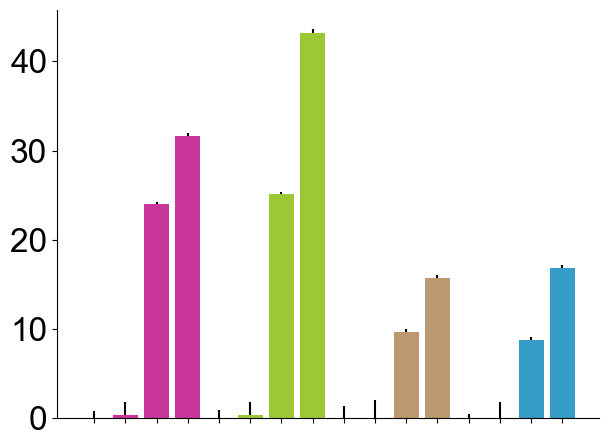

In [22]:
fig, ax =setup_figure()
ax.set_xticks(np.arange(0,len(cqdata.iloc[:,0]),1))
ax.set_xticklabels([""]*len(cqdata.iloc[:,0]))
colorpallette=["#bb0383","#bb0383","#bb0383","#bb0383","#83bb03","#83bb03","#83bb03","#83bb03","#AB7E4C","#AB7E4C","#AB7E4C","#AB7E4C","#0383bb","#0383bb","#0383bb","#0383bb"]
ax.bar(cqdata.iloc[:,0],cqdata.iloc[:,-1],yerr=[np.zeros(len(cqdata.iloc[:,-2])),cqdata.iloc[:,-2]],color=colorpallette,alpha=0.8)
os.makedirs("Figure/SupFigure1/PanelA/",exist_ok=True)
fig.savefig("Figure/SupFigure1/PanelA/Sup1A_qPCR.png",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig("Figure/SupFigure1/PanelA/Sup1A_qPCR.pdf",dpi=300,bbox_inches='tight',transparent=True)
fig.savefig("Figure/SupFigure1/PanelA/Sup1A_qPCR.svg",dpi=300,bbox_inches='tight',transparent=True)
plt.show()  